In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/home/sam/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


In [2]:
series = read_csv('../data/single bill for cluster 0.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values = series.values

In [3]:
series2 = read_csv('../data/single bill for cluster 1.csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values2 = series2.values

In [4]:
series3 = read_csv('../data/single bill for cluster 2.csv .csv', usecols=[1], engine='python')
# transform data to be stationary
raw_values3 = series3.values

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [7]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

### For Cluster 0

In [8]:
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.01624356],
       [-0.66504323],
       [ 0.5333264 ],
       [-0.04345846],
       [ 0.4396793 ],
       [-0.10145509],
       [ 0.42999783],
       [ 0.45308393],
       [-0.12024716],
       [-0.60630953],
       [ 0.08259171],
       [-0.30902648],
       [ 0.49146923],
       [ 0.04489651],
       [ 0.428034  ],
       [-0.1735067 ],
       [-0.4896272 ],
       [-0.4688606 ],
       [ 0.5043963 ],
       [-0.06686425],
       [-0.47140488],
       [ 0.5096488 ],
       [-0.07361872],
       [ 0.48807025],
       [-0.10223344],
       [-0.2686288 ],
       [ 0.49484587],
       [-0.04220606],
       [-0.05777766],
       [-0.42456618],
       [ 0.11563793],
       [ 0.08797011],
       [ 0.47099638],
       [ 0.24715966],
       [-0.41111216],
       [ 0.47367007],
       [-0.06858605],
       [-0.44374874],
       [ 0.2950661 ],
       [-0.3036224 ],
       [ 0.4892283 ],
       [ 0.04267745],
       [ 0.47865808],
       [-0.11378527]], dtype=float32)

In [9]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 16ms/step
Month=1, Predicted=1507.132337, Expected=2107.000000
1/1 [==============================] - 0s 19ms/step
Month=2, Predicted=1346.610995, Expected=1324.000000
1/1 [==============================] - 0s 16ms/step
Month=3, Predicted=2073.522733, Expected=1050.000000


Test RMSE: 685.067
Test MAE: 548.667


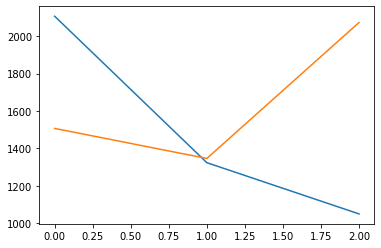

In [10]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 1

In [11]:
diff_values2 = difference(raw_values2, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values2, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 1ms/step


array([[ 0.25767186],
       [-0.5049919 ],
       [ 0.15109634],
       [-0.5506119 ],
       [-0.27764833],
       [ 0.27441043],
       [-0.57592374],
       [ 0.09026479],
       [ 0.13745506],
       [-0.11057241],
       [-0.74794513],
       [-0.31689876],
       [ 0.05481504],
       [-0.005051  ],
       [-0.20535138],
       [ 0.38168696],
       [-0.3396678 ],
       [-0.38835633],
       [ 0.26556534],
       [-0.02529842],
       [-0.14475355],
       [ 0.24631557],
       [-0.08776714],
       [ 0.17730784],
       [-0.3781707 ],
       [ 0.25643718],
       [-0.19537148],
       [-0.4151293 ],
       [-0.551238  ],
       [ 0.10389686],
       [ 0.451548  ],
       [-0.36371118],
       [-0.5565642 ],
       [ 0.07130674],
       [ 0.50071853],
       [-0.4662292 ],
       [ 0.17741644],
       [ 0.01181247],
       [ 0.47147965],
       [ 0.35031015],
       [-0.03454481],
       [ 0.36965594],
       [ 0.5589577 ],
       [ 0.47691873]], dtype=float32)

In [12]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values2, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values2[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=303.684607, Expected=53.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=146.101494, Expected=185.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=117.145428, Expected=52.000000


Test RMSE: 151.217
Test MAE: 151.217


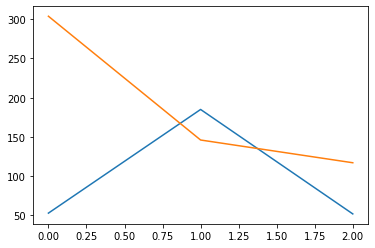

In [13]:
# report performance
rmse = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = sqrt(mean_squared_error(raw_values2[-3:], predictions))
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values2[-3:])
pyplot.plot(predictions)
pyplot.show()

### For Cluster 2

In [14]:
diff_values3 = difference(raw_values3, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values3, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-3], supervised_values[-3:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


44/44 [==============================] - 0s 918us/step


array([[-0.10207488],
       [-0.45067358],
       [-0.22613159],
       [-0.5553447 ],
       [-0.10844368],
       [ 0.05456425],
       [-0.23574579],
       [ 0.00701722],
       [ 0.19498019],
       [-0.3442875 ],
       [ 0.320593  ],
       [ 0.13988306],
       [-0.45878392],
       [-0.20979027],
       [-0.17762977],
       [-0.42468297],
       [ 0.29351395],
       [-0.602639  ],
       [ 0.20020328],
       [-0.17717081],
       [ 0.35061866],
       [ 0.00061932],
       [-0.5776624 ],
       [-0.2771613 ],
       [ 0.25004202],
       [ 0.50103635],
       [ 0.43087083],
       [-0.47024488],
       [ 0.06526439],
       [ 0.00286604],
       [-0.11077981],
       [ 0.1639217 ],
       [ 0.33446813],
       [ 0.08500305],
       [-0.28441805],
       [ 0.30135155],
       [-0.03611847],
       [ 0.05676283],
       [-0.401798  ],
       [ 0.18076755],
       [-0.11384147],
       [ 0.10565025],
       [ 0.41369927],
       [ 0.06650332]], dtype=float32)

In [15]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values3, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values3[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 0s 17ms/step
Month=1, Predicted=2964.136482, Expected=2889.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=3013.266735, Expected=2209.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=2872.208411, Expected=2589.000000


Test RMSE: 494.199
Test MAE: 1456.204


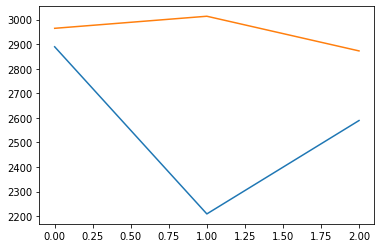

In [16]:
# report performance
rmse = sqrt(mean_squared_error(raw_values3[-3:], predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(raw_values[-3:], predictions)
print('Test MAE: %.3f' % mae)
# line plot of observed vs predicted
pyplot.plot(raw_values3[-3:])
pyplot.plot(predictions)
pyplot.show()